# Импортируем модули.

In [1]:
import os

import matplotlib.pyplot as plt
import skimage as sk

import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
import keras.layers as layers

# Загрузка файлов

Введем константы

In [2]:
SEED = 5115
IMG_SIZE = (160, 160)
NUM_CLASSES = 3
LABEL_OXIDE = '_1'
LABEL_METAL = '_2'
INPUT_DIR = './images_160/images/'
TARGET_DIR = './images_160/segments/'

Создадим списки с названиями исследуемых изображений и разметки.

In [3]:
input_paths = sorted(
    [os.path.join(INPUT_DIR, file_name)
     for file_name in os.listdir(INPUT_DIR)
     if file_name.endswith('.jpg')])

target_paths = sorted(
    [os.path.join(TARGET_DIR, file_name)
     for file_name in os.listdir(TARGET_DIR)
     if file_name.endswith('.png')])

print('Количество изображений:', len(input_paths))
print('Количество файлов разметки:', len(target_paths))
for i in range(5):
    print(input_paths[i], '|', target_paths[i])

Количество изображений: 34
Количество файлов разметки: 63
./images_160/images/ETD_1_001_1.jpg | ./images_160/segments/ETD_1_001_1_1.png
./images_160/images/ETD_1_001_2.jpg | ./images_160/segments/ETD_1_001_1_2.png
./images_160/images/ETD_1_001_3.jpg | ./images_160/segments/ETD_1_001_2_1.png
./images_160/images/ETD_1_002_1.jpg | ./images_160/segments/ETD_1_001_2_2.png
./images_160/images/ETD_1_002_2.jpg | ./images_160/segments/ETD_1_001_3_1.png


Создадим массив изображений.

In [4]:
def files_to_arrays(input_dir, target_dir):

    input_img_paths = [os.path.join(input_dir, file_name)
                       for file_name in os.listdir(input_dir)
                       if file_name.endswith('.jpg')]
    random.Random(SEED).shuffle(input_img_paths)

    target_img_paths = [os.path.join(target_dir, file_name)
                        for file_name in os.listdir(target_dir)
                        if file_name.endswith('.png')]

    X_list = []
    for i in input_img_paths:
        image = plt.imread(i)
        image = sk.color.rgb2gray(image)
        X_list.append(image)

    X = np.array(X_list).astype('float32')
    X = np.expand_dims(X, 3)

    y_list = []
    for i in input_img_paths:
        input_name = i.replace(input_dir, '').replace('.jpg', '')
        target_array = np.zeros(IMG_SIZE + (2,))
        target_array = np.insert(target_array, 0, np.ones(IMG_SIZE), axis=2)

        for j in target_img_paths:
            target_name = j.replace(target_dir, '').replace('.png', '')
            if target_name.startswith(input_name) and target_name.endswith(LABEL_OXIDE):
                target_array[:,:,1] += plt.imread(j)
            elif target_name.startswith(input_name) and target_name.endswith(LABEL_METAL):
                target_array[:,:,2] += plt.imread(j)

        mask_background = np.logical_and(np.logical_or(target_array[:,:,1], target_array[:,:,2]),
                                         target_array[:,:,0])
        target_array[:,:,0] *= np.logical_not(mask_background)
        mask_metal = np.logical_and(target_array[:,:,1], target_array[:,:,2])
        target_array[:,:,2] *= np.logical_not(mask_metal)
        target_array = np.ceil(target_array).astype('uint8')
        y_list.append(target_array)

    y = np.array(y_list)

    return X, y

In [5]:
X, y = files_to_arrays(INPUT_DIR, TARGET_DIR)

print('Размер массива изображений:', X.shape)
print('Min X =', X.min(), '|', 'Max X =', X.max())

print('Размер массива разметки:', y.shape)
print('Min y =', y.min(), '|', 'Max y =', y.max())
print('Количество попарных пересечений между классами разметки:',
      np.logical_and(y[..., 0], y[..., 1]).sum() +
      np.logical_and(y[..., 0], y[..., 2]).sum() +
      np.logical_and(y[..., 1], y[..., 2]).sum())

Размер массива изображений: (34, 160, 160, 1)
Min X = 0.0 | Max X = 1.0
Размер массива разметки: (34, 160, 160, 3)
Min y = 0 | Max y = 1
Количество попарных пересечений между классами разметки: 0


Разделим полученный массив на тренировочную и тестовую выборки.

In [7]:
test_size = X.shape[0] // 5
X_train = X[:-test_size]
y_train = y[:-test_size]

X_test = X[-test_size:]
y_test = y[-test_size:]

print('Количество изображений в тренировочном массиве:', X_train.shape[0])
print('Количество изображений в тестовом массиве:', X_test.shape[0])

Количество изображений в тренировочном массиве: 28
Количество изображений в тестовом массиве: 6


Проверим соответствие массивов изображений и разметки.

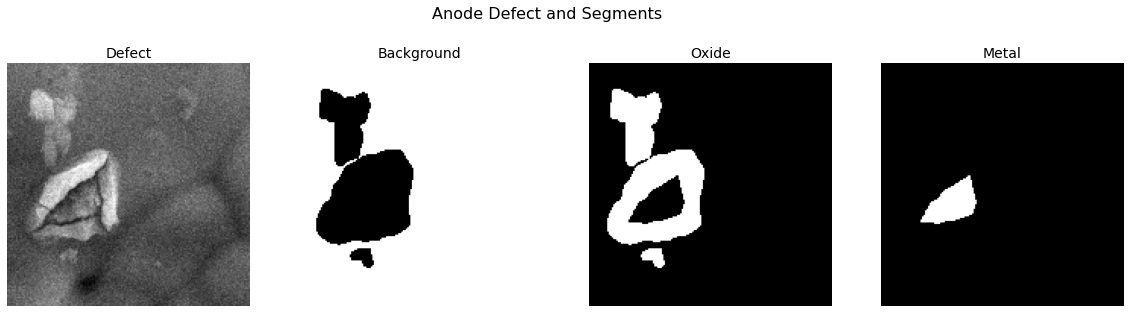

In [9]:
idx = 5

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))

ax[0].imshow(X_train[idx], cmap='gray')
ax[0].set_title('Defect', size=14)
ax[0].axis('off')

for i, j in zip(range(1, 4), ['Background', 'Oxide', 'Metal']):
    ax[i].imshow(y_train[idx, :, :, i - 1], cmap='gray')
    ax[i].set_title(j, size=14)
    ax[i].axis('off')

fig.suptitle('Anode Defect and Segments', size=16, y=0.75)
plt.show()

# Подготовка модели

In [10]:
def get_unet(img_size=IMG_SIZE, num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=img_size + (1,))
    # Down 1
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Dropout(0.2)(conv1)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    # Down 2
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Dropout(0.2)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    # Down 3
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Dropout(0.2)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    # Down 4
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Dropout(0.2)(conv4)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    # Bottleneck
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Dropout(0.2)(conv5)
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Up 1
    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Dropout(0.2)(conv6)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Up 2
    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Dropout(0.2)(conv7)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Up 3
    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = layers.Dropout(0.2)(conv8)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Up 4
    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = layers.Dropout(0.2)(conv9)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    # Output
    conv10 = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(conv9)

    model_unet = keras.Model(inputs=[inputs], outputs=[conv10])

    return model_unet

In [11]:
model = get_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 160, 160, 32  0           ['conv2d[0][0]']                 
                                )                                                             

# Тренировка модели

In [12]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
              loss="categorical_crossentropy",
              metrics=[tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES), 'accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint("anode_defects_unet.h5", save_best_only=True)]

epochs = 20
model.fit(X_train, y_train, epochs=epochs, batch_size=None, validation_split=0.2, verbose=1, callbacks=callbacks)

Epoch 1/20
1/1 [==============================] - 28s 28s/step - loss: 1.1243 - mean_io_u: 0.3333 - accuracy: 0.0374 - val_loss: 0.9370 - val_mean_io_u: 0.3333 - val_accuracy: 0.9201
Epoch 2/20
1/1 [==============================] - 19s 19s/step - loss: 0.8817 - mean_io_u: 0.3333 - accuracy: 0.9526 - val_loss: 695.0906 - val_mean_io_u: 0.8876 - val_accuracy: 0.9201
Epoch 3/20
1/1 [==============================] - 19s 19s/step - loss: 674.8861 - mean_io_u: 0.9329 - accuracy: 0.9536 - val_loss: 0.6761 - val_mean_io_u: 0.3333 - val_accuracy: 0.9201
Epoch 4/20
1/1 [==============================] - 19s 19s/step - loss: 0.5790 - mean_io_u: 0.3333 - accuracy: 0.9534 - val_loss: 0.9874 - val_mean_io_u: 0.3333 - val_accuracy: 0.9201
Epoch 5/20
1/1 [==============================] - 20s 20s/step - loss: 0.9740 - mean_io_u: 0.3333 - accuracy: 0.9532 - val_loss: 1.0175 - val_mean_io_u: 0.3333 - val_accuracy: 0.9201
Epoch 6/20
1/1 [==============================] - 22s 22s/step - loss: 1.0121 - m

# Предсказание

In [24]:
best_model = keras.models.load_model('anode_defects_unet.h5')

test_results = best_model.evaluate(X_test, y_test)
print('X_test - Loss, Mean_I_o_U, Accuracy', test_results)

y_prob = best_model.predict(X_test)
print('Shape of y_pred:', y_prob.shape)

1/1 [==============================] - 2s 2s/step - loss: 0.1170 - mean_io_u: 0.3333 - accuracy: 0.9843
X_test - Loss, Mean_I_o_U, Accuracy [0.1169528141617775, 0.3333333432674408, 0.9843229055404663]
1/1 [==============================] - 2s 2s/step
Shape of y_pred: (6, 160, 160, 3)


In [14]:
for i1, i2 in zip(['Максимальные значения по каналам:',
                   'Медианные значения по каналам:',
                   'Минимальные значения по каналам:'], range(3)):
    if i2 > 0:
        print()
    print(i1, end=' ')
    for j in range(3):
        if i2 == 0:
            print(np.max(y_prob[..., j]), end=' ')
        elif i2 == 1:
            print(np.median(y_prob[..., j]), end=' ')
        elif i2 == 2:
            print(np.min(y_prob[..., j]), end=' ')

Максимальные значения по каналам: 0.996808 0.26955923 0.2659702 
Медианные значения по каналам: 0.9867989 0.010072849 0.0029922244 
Минимальные значения по каналам: 0.46596357 0.0024937221 0.0006074335 

In [15]:
y_pred = y_prob.copy()
# y_pred = np.where(y_pred > 0.04, 1, 0).astype('uint8')

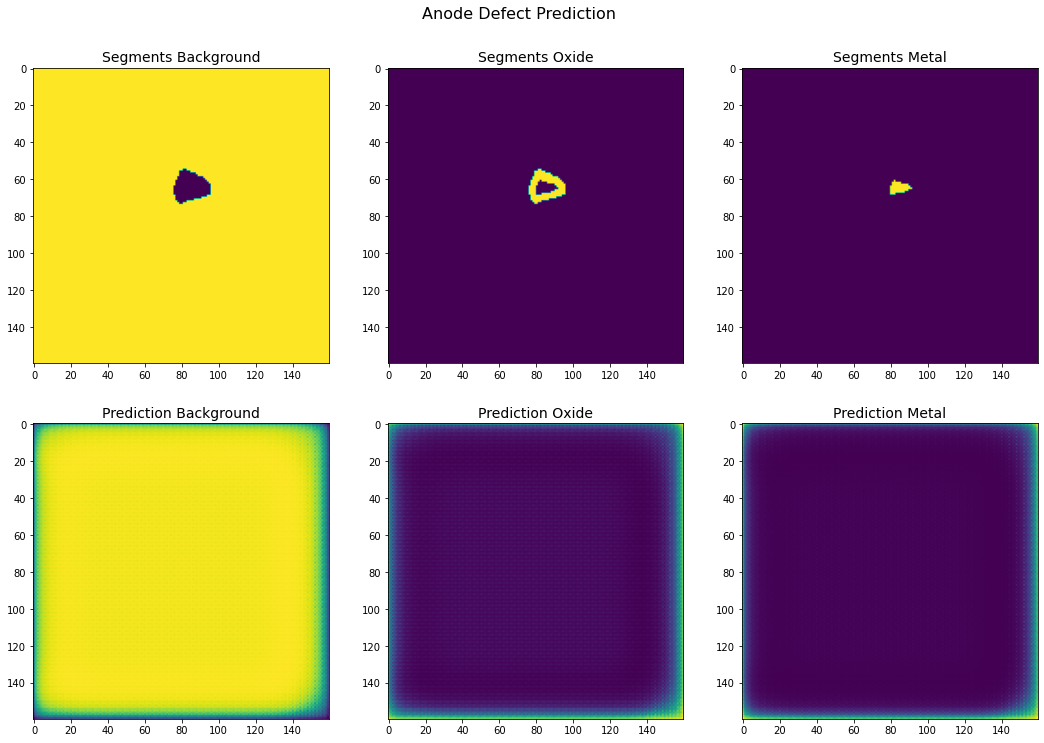

Defect Area on Segments (pixels):
Background: 25342
Oxide: 199
Metal: 59

Defect Area on Prediction (pixels):
Background: 24611.281
Oxide: 617.22675
Metal: 371.49078



In [22]:
idx_test = 5

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,12))

for i1, i2, i3 in zip(range(2), [y_test, y_pred], ['Segments', 'Prediction']):
    for j1, j2 in zip(range(3), ['Background', 'Oxide', 'Metal']):
        ax[i1, j1].imshow(i2[idx_test,:,:,j1])
        ax[i1, j1].set_title(' '.join([i3, j2]), size=14)

fig.suptitle("Anode Defect Prediction", size=16, y=0.95)
plt.show()

for i1, i2 in zip(['Defect Area on Segments (pixels):',
                   'Defect Area on Prediction (pixels):'],
                  [y_test, y_pred]):
    print(i1)
    for j1, j2 in zip(['Background:', 'Oxide:', 'Metal:'], range(3)):
        print(j1, i2[idx_test,:,:,j2].sum())
    print()